<a href="https://colab.research.google.com/github/rijulb17/ZS-DS-Question/blob/master/Course_project_intel_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os 

# Set your working directory to a folder in your Google Drive. This way, if your notebook times out,
# your files will be saved in your Google Drive!

# the base Google Drive directory
root_dir = "/content/drive/My Drive/"

# choose where you want your project files to be saved
project_folder = "Colab Notebooks/My Project Folder/"

def create_and_set_working_directory(project_folder):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')

  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + project_folder)

  # create a test file to make sure it shows up in the right place
  !touch 'new_file_in_working_directory.txt'
  print('\nYour working directory was changed to ' + root_dir + project_folder + \
        "\n\nAn empty text file was created there. You can also run !pwd to confirm the current working directory." )

create_and_set_working_directory(project_folder)

/content/drive/My Drive/Colab Notebooks/My Project Folder/ did not exist but was created.

Your working directory was changed to /content/drive/My Drive/Colab Notebooks/My Project Folder/

An empty text file was created there. You can also run !pwd to confirm the current working directory.


In [4]:
!pwd

/content/drive/My Drive/Colab Notebooks/My Project Folder


In [5]:
! pip install -q kaggle

In [6]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rijulbathla","key":"6c65e5cfdd3bf0fda2b3de9e5fac2c02"}'}

In [7]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [8]:
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
! kaggle datasets download -d puneet6060/intel-image-classification

 98% 340M/346M [00:04<00:00, 81.8MB/s]
100% 346M/346M [00:04<00:00, 73.7MB/s]


In [10]:
! mkdir intel_image_data

In [11]:
! unzip intel-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

In [74]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.utils.colab.set_colab_file_id(jovian.utils.colab.get_colab_file_id())


In [20]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as T
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
%matplotlib inline

In [14]:
!pwd

/content/drive/My Drive/Colab Notebooks/My Project Folder


In [18]:
DATA_DIR = '.'

TRAIN_DIR = DATA_DIR + '/seg_train/seg_train'                           # Contains training images
TEST_DIR = DATA_DIR + '/seg_test/seg_test'                             # Contains test images

In [19]:
print(os.listdir(DATA_DIR))
classes = os.listdir(TRAIN_DIR)
print(classes)

['new_file_in_working_directory.txt', 'kaggle.json', 'intel-image-classification.zip', 'intel_image_data', 'seg_pred', 'seg_test', 'seg_train']
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [22]:
image_size = 64
batch_size = 128

imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_ds = ImageFolder(TRAIN_DIR, 
                      transform=T.Compose([ T.Resize(image_size),
                                            T.CenterCrop(image_size),
                                            T.ToTensor(),
                                            T.Normalize(*imagenet_stats)] ) )

In [32]:
test_ds = ImageFolder(TEST_DIR, 
                      transform=T.Compose([ T.Resize(image_size),
                                            T.CenterCrop(image_size),
                                            T.ToTensor(),
                                            T.Normalize(*imagenet_stats)] ) )

In [36]:
PRED_DIR = DATA_DIR + '/seg_pred'         

pred_ds = ImageFolder(PRED_DIR, 
                      transform=T.Compose([ T.Resize(image_size),
                                            T.CenterCrop(image_size),
                                            T.ToTensor(),
                                            T.Normalize(*imagenet_stats)] ) )

In [37]:
len(train_ds) , len(test_ds), len(pred_ds)

(14034, 3000, 7301)

In [27]:
def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:', train_ds.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

Label: buildings (0)


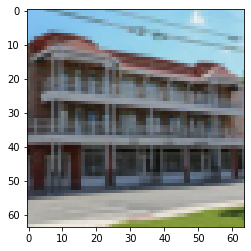

In [28]:
show_image(*train_ds[2])

Label: buildings (0)


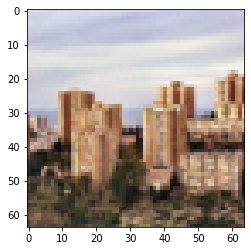

In [29]:
show_image(*train_ds[28])

Label: forest (1)


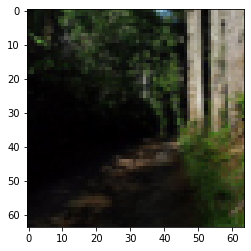

In [30]:
show_image(*train_ds[2856])

Label: glacier (2)


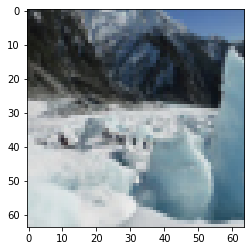

In [31]:
show_image(*train_ds[6856])

In [38]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)

In [42]:
def show_batch(dl):
    for images, labels in dl:
          fig, ax = plt.subplots(figsize=(16, 16))
          ax.set_xticks([]); ax.set_yticks([])
          images = denormalize(images[:64], *imagenet_stats)
          ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
          break

In [45]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))

In [46]:
class IntelImageClassification(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [47]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [48]:
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [49]:
device = get_default_device()
device

device(type='cuda')

In [50]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [51]:
model = IntelImageClassification(len(classes))
to_device(model, device);

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [52]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.246221125125885, 'val_loss': 2.505361318588257}]

In [53]:
epochs = 6
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [54]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0],last_lr: 0.00600, train_loss: 0.5414, val_loss: 2.5263, val_acc: 0.3961



Epoch [1],last_lr: 0.00994, train_loss: 0.9914, val_loss: 1.0092, val_acc: 0.6211



Epoch [2],last_lr: 0.00812, train_loss: 0.7601, val_loss: 0.6640, val_acc: 0.7688



Epoch [3],last_lr: 0.00463, train_loss: 0.5748, val_loss: 0.5565, val_acc: 0.8040



Epoch [4],last_lr: 0.00133, train_loss: 0.4554, val_loss: 0.4899, val_acc: 0.8298



Epoch [5],last_lr: 0.00000, train_loss: 0.3589, val_loss: 0.4220, val_acc: 0.8593
CPU times: user 47.2 s, sys: 7.66 s, total: 54.9 s
Wall time: 2min 54s


In [56]:
jovian.log_hyperparams(max_lr=max_lr, epochs=epochs)

[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Hyperparams logged.


In [60]:
torch.save(model.state_dict(), 'IntelImageClassification.pth')

In [62]:
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'],
                   train_loss=history[-1]['train_loss'])

[jovian] Metrics logged.


In [75]:
jovian.commit(project='Course_Project_IntelImageClassification', environment=None, outputs=['IntelImageClassification.pth'])

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...


ApiError: ignored

In [76]:
jovian.commit(project='abc')

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...


ApiError: ignored